In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

%config InlineBackend.figure_format = 'retina'

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

## Setting datasets up

check if ids and names are consistent in time

In [2]:
n=30000
random_seed=42
years=[17,18,19,20]

In [3]:
data={}

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
%%time

N=500000

data[17]=pd.read_csv('../ENEM/MICRODADOS_ENEM_2017.csv', sep=';', encoding='latin1', nrows=N)
data[18]=pd.read_csv('../ENEM/microdados_enem_2018/DADOS/MICRODADOS_ENEM_2018.csv', sep=';', encoding='latin1', nrows=N)
data[19]=pd.read_csv('../ENEM/microdados_enem_2019/DADOS/MICRODADOS_ENEM_2019.csv', sep=';', encoding='latin1', nrows=N)
data[20]=pd.read_csv('../ENEM/microdados_enem_2020/DADOS/MICRODADOS_ENEM_2020.csv', sep=';', encoding='latin1', nrows=N)

data[17].shape, data[18].shape, data[19].shape, data[20].shape

CPU times: user 41.4 s, sys: 4.22 s, total: 45.6 s
Wall time: 48.3 s


((500000, 137), (500000, 137), (500000, 136), (500000, 76))

In [6]:
for year in years:
    data[year]=data[year].loc[data[year]['TP_PRESENCA_MT']==1,:]
    data[year]=data[year].loc[data[year]['NU_NOTA_MT']>=300,:]
    data[year]['y']=np.log(data[year]['NU_NOTA_MT'])
    print(data[year].shape)

(372074, 138)
(371169, 138)
(388355, 137)
(302995, 77)


In [7]:
for year in years:
    data[year]=data[year][['TP_SEXO','TP_COR_RACA','TP_ESCOLA',
                           'Q001','Q002','Q003','Q006','Q010','Q024',
                           'y']]
    data[year]=data[year].dropna()
    data[year]=data[year].sample(n)
    print(data[year].shape)

(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)


In [8]:
X,y={},{}
X_train,y_train={},{}
X_val,y_val={},{}
X_test,y_test={},{}

for year in years:
    X[year] = data[year][['TP_SEXO','TP_COR_RACA','TP_ESCOLA',
                          'Q002','Q006','Q024']]
    X[year]=X[year].astype(str)
    y[year] = data[year][['y']]

In [9]:
cat_features=list(range(X[19].shape[1]))

Checking if cde_reg is a good cd model:

  0%|          | 0/4 [00:00<?, ?it/s]

********* 0 *********


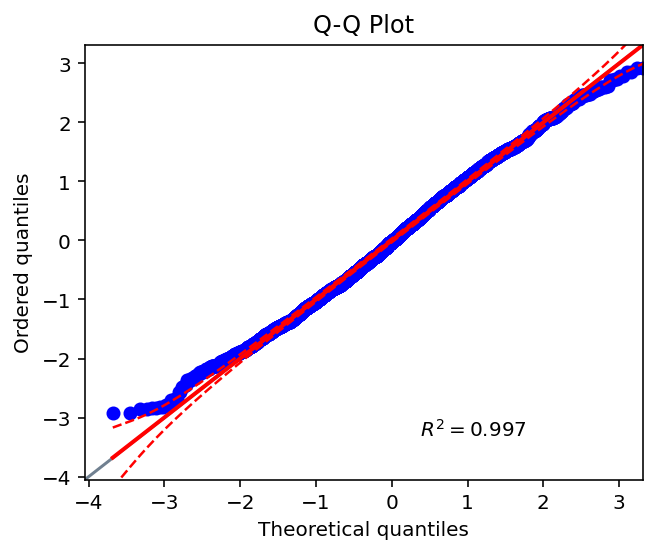

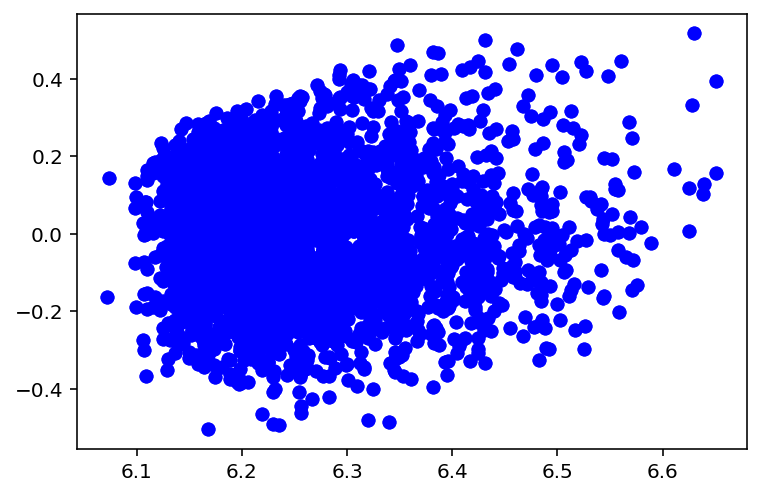

 25%|██▌       | 1/4 [00:11<00:34, 11.43s/it]

********* 1 *********


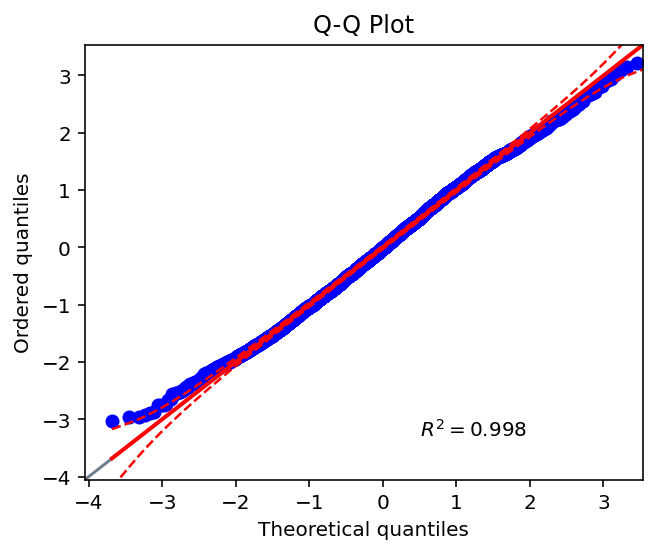

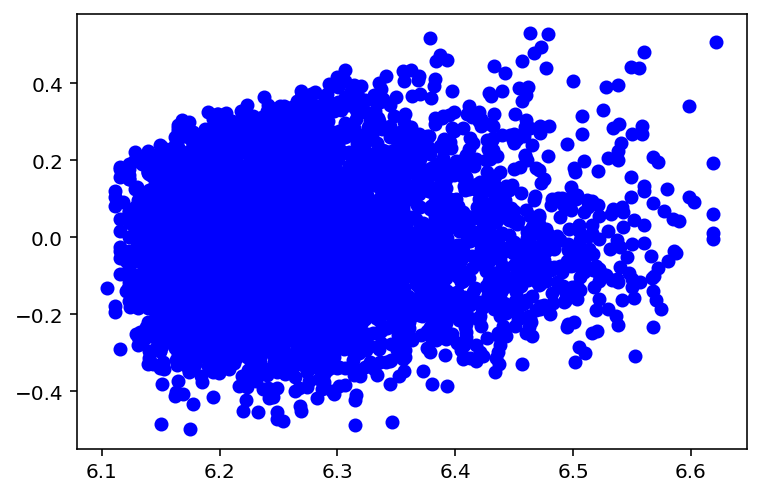

 50%|█████     | 2/4 [00:14<00:12,  6.40s/it]

********* 2 *********


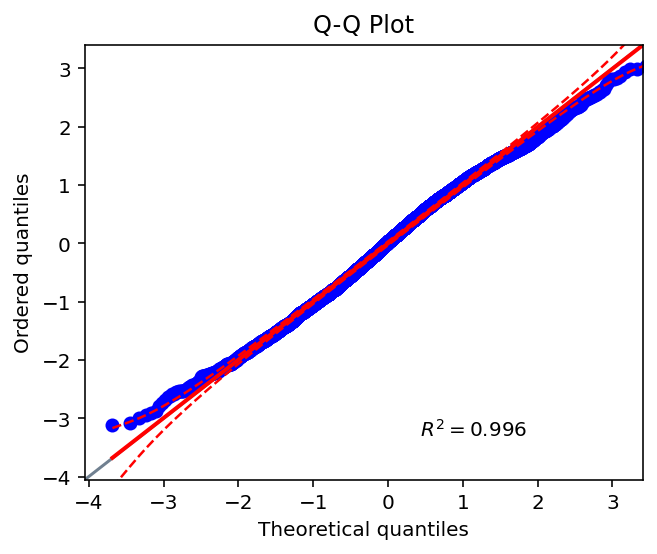

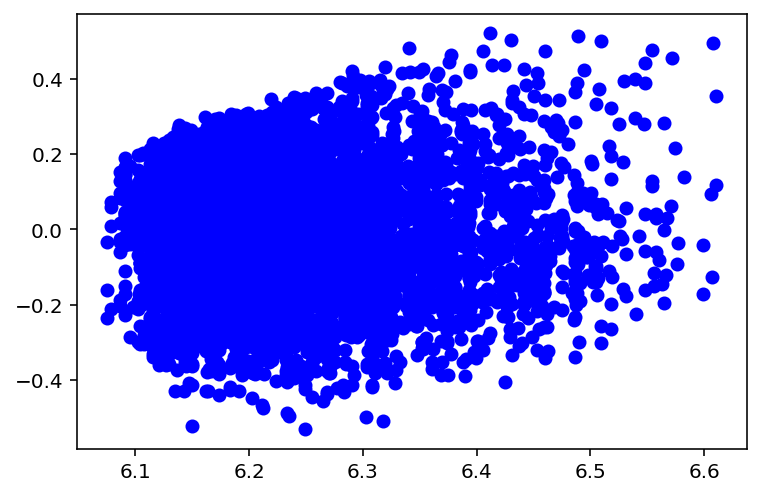

 75%|███████▌  | 3/4 [00:16<00:04,  4.47s/it]

********* 3 *********


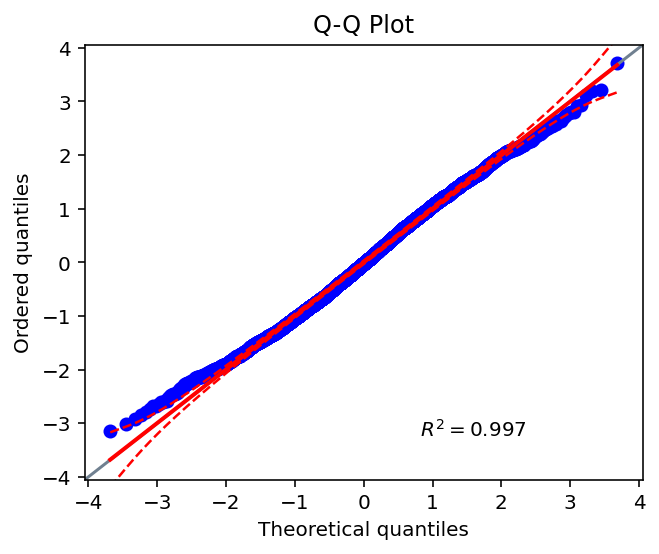

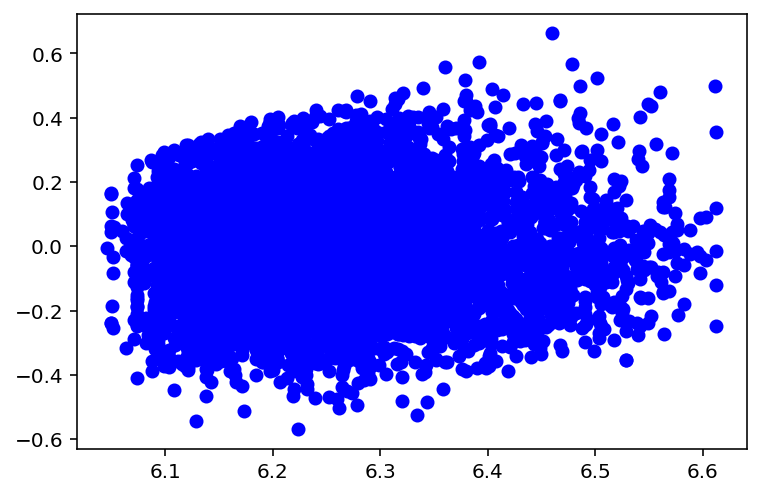

100%|██████████| 4/4 [00:19<00:00,  4.76s/it]


In [10]:
from pingouin import qqplot
task='reg'

for t in tqdm(range(0,4)):
    
    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
    Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(X[years[0]], y[years[0]], X[years[t]], y[years[t]], test=.1, task=task, random_state=random_seed)

    cd_model = cde_reg(boost=True, cat_features=cat_features)
    cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                 pd.concat([ys_train, yt_train], axis=0))
    
    y_hat=cd_model.model.predict(pd.concat([Xs_test, Xt_test], axis=0)).squeeze()
    e=y_hat-np.array(pd.concat([ys_test, yt_test], axis=0)).squeeze()
    
    print("********* {:} *********".format(t))
    qqplot(e)
    plt.show()
    plt.plot(y_hat,e,'bo')
    plt.show()

Results

In [11]:
pvals=[]
kls=[]
task='reg'
B=250

for t in tqdm(range(0,4)):
    
    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
    Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(X[years[0]], y[years[0]], X[years[t]], y[years[t]], test=.1, task=task, random_state=random_seed)
    
    ### Training models
    totshift_model = KL(boost=True, cat_features=cat_features)
    totshift_model.fit(Zs_train, Zt_train)
    covshift_model = KL(boost=True, cat_features=cat_features)
    covshift_model.fit(Xs_train, Xt_train)
    labshift_model = KL(boost=True)
    labshift_model.fit(ys_train, yt_train)

    cd_model = cde_reg(boost=True, cat_features=cat_features)
    cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                 pd.concat([ys_train, yt_train], axis=0))

    ### Getting test statistics and p-vals
    out = ShiftDiagnostics(Xs_test, ys_test, Xt_test, yt_test,
                           totshift_model=totshift_model, covshift_model=covshift_model, labshift_model=labshift_model,
                           cd_model=cd_model, task=task, n_bins=10, B=B, verbose=False)
    
    ### Output
    pvals.append([t, out['lab']['pval'], out['cov']['pval'], out['conc1']['pval'], out['conc2']['pval'], out['tot']['pval']])
    kls.append([t, out['lab']['kl'], out['cov']['kl'], out['conc1']['kl'], out['conc2']['kl'], out['tot']['kl']])


100%|██████████| 4/4 [02:44<00:00, 41.19s/it]


In [12]:
kls=np.array(kls)
pvals=np.array(pvals)

In [13]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots

In [14]:
years_lab=['2017', '2018', '2019', '2020']

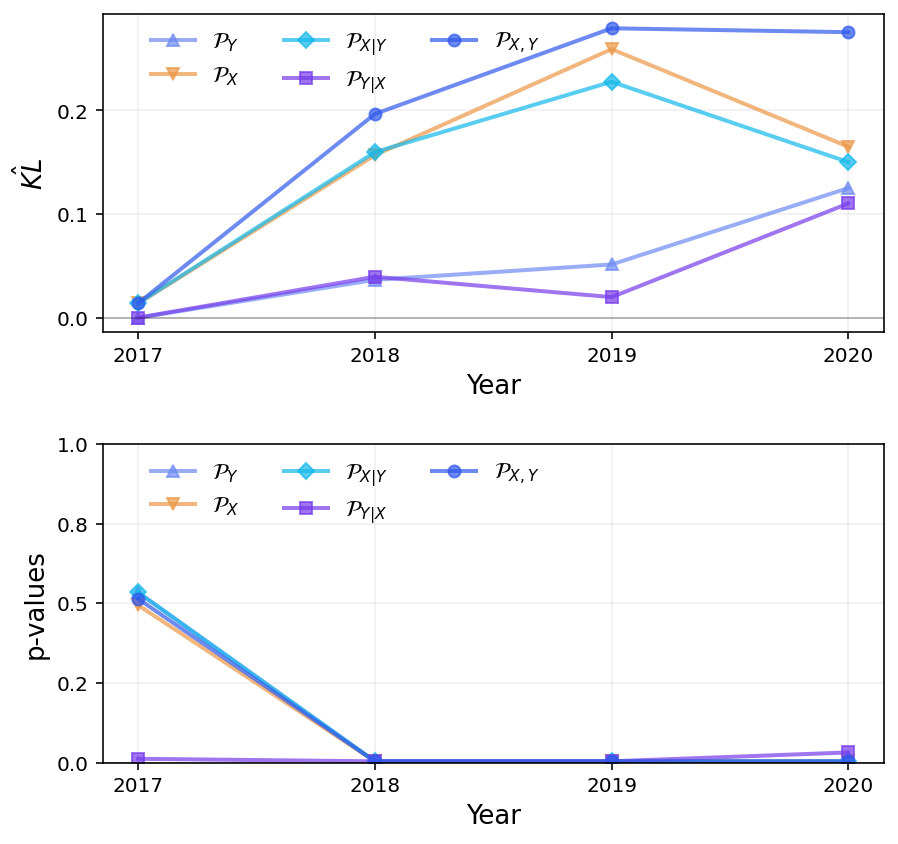

In [15]:
plt.figure(figsize=(7,6.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(2, 1, 1)
exp_plots(years_lab[:], kls[:], xlab="Year", ylab="$\hat{KL}$", grid='both')

plt.subplot(2, 1, 2)
exp_plots(years_lab[:], pvals[:], xlab="Year", ylab="p-values", grid='both')
plt.ylim(0,1)
plt.savefig('plots/enem.png', bbox_inches='tight', dpi=300, transparent=True)